# AB Diblock Copolymers in Potential Fields

This tutorial demonstrates how to compute partition functions, propagators, and concentrations of AB diblock copolymers in external potential fields.

**What you'll learn:**
- Setting up an AB diblock copolymer simulation
- Computing chain propagators (forward and backward)
- Calculating single-chain partition functions
- Computing ensemble-averaged concentrations
- Visualizing propagator evolution with animations

**Prerequisites:** Complete the `00_QuickStart.ipynb` tutorial first.

## 1. Setup and Imports

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"      # Optimize threading
os.environ["MKL_NUM_THREADS"] = "1"      # Single-threaded MKL

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from IPython.display import HTML

# Import polymerfts
import polymerfts
from polymerfts import PropagatorSolver

## 2. Simulation Parameters

We use the following parameters:

| Parameter | Value | Description |
|-----------|-------|-------------|
| $N$ | 100 | Reference chain length (number of statistical segments) |
| $\Delta s$ | 0.01 | Contour step size (= $1/N$) |
| $L_x, L_y$ | $5.0 R_0$ | Box dimensions in units of $R_0 = b\sqrt{N}$ |
| $m_x, m_y$ | 64 | Grid points per dimension |
| $b_A/b, b_B/b$ | 1.0 | Statistical segment lengths (relative to reference $b$) |
| $f_A$ | 0.7 | A block fraction (70% of chain) |
| $f_B$ | 0.3 | B block fraction (30% of chain) |

**Note on ds:** The choice `ds = 0.01` means we're modeling a chain of $N = 1/ds = 100$ statistical segments. Smaller `ds` gives higher numerical accuracy but increases computation time. Typical values range from 0.005 to 0.02.

In [2]:
# Simulation parameters
nx = [64, 64]              # Grid points
lx = [5.0, 5.0]            # Box size (in units of R0 = b*sqrt(N))
ds = 0.01                  # Contour step interval

# Block fractions
f_A = 0.7
f_B = 0.3

## 3. Create the Solver

We use `PropagatorSolver` for a clean, simple interface. The solver automatically:
- Selects the appropriate platform (CPU or GPU)
- Creates the computation grid
- Sets up the pseudo-spectral method for solving diffusion equations

In [3]:
# Create solver
solver = PropagatorSolver(
    nx=nx,
    lx=lx,
    ds=ds,
    bond_lengths={"A": 1.0, "B": 1.0},
    bc=["periodic"]*4,
    chain_model="continuous",
    method="pseudospectral",
    platform="cpu-mkl",
    reduce_memory_usage=False
)

# Add AB diblock copolymer with f_A = 0.7 and f_B = 0.3
# Graph notation: nodes [0, 1, 2] connected by blocks [0→1, 1→2]
solver.add_polymer(
    volume_fraction=1.0,
    blocks=[
        ["A", f_A, 0, 1],  # A block from node 0 to node 1
        ["B", f_B, 1, 2]   # B block from node 1 to node 2
    ]
)

print(solver.info)

PropagatorSolver Configuration:
  Dimensions: 2D
  Grid: [64, 64]
  Box size: [5.0, 5.0]
  Boundary conditions: ['periodic', 'periodic', 'periodic', 'periodic']
  Chain model: continuous
  Contour step (ds): 0.01
  Method: pseudospectral
  Platform: cpu-mkl
  Monomer types: ['A', 'B']


## 4. Set Potential Fields

The monomer potential fields $w_A(\mathbf{r})$ and $w_B(\mathbf{r})$ determine where each monomer type prefers to be through **Boltzmann weighting**:

$$\text{local weight} \propto e^{-w_\alpha(\mathbf{r})}$$

This means:
- $w < 0$: **Attractive** — $e^{-w} > 1$, monomers are favored here
- $w > 0$: **Repulsive** — $e^{-w} < 1$, monomers avoid this region

We create sinusoidal potentials that are **opposite** for A and B, mimicking the chemical incompatibility that drives phase separation in real block copolymers:

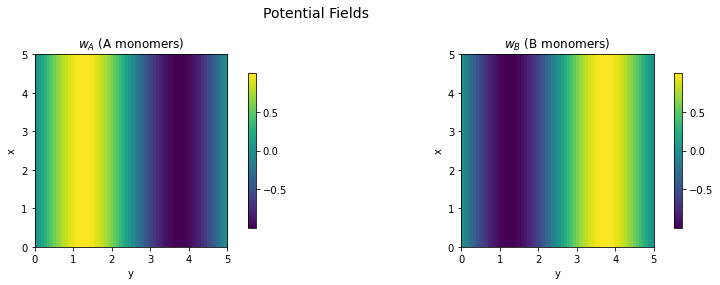

Yellow = high w (repulsive), Purple = low w (attractive)


In [4]:
# Create sinusoidal potential fields (opposite for A and B)
w_A = np.tile(np.sin(np.linspace(0, 2*np.pi, nx[0])), (nx[1], 1))
w_B = -w_A  # Opposite preference

# Visualize the potential fields
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Potential Fields", fontsize=14)

im0 = axes[0].imshow(w_A, extent=(0, lx[1], 0, lx[0]), origin='lower', cmap='viridis')
axes[0].set(title='$w_A$ (A monomers)', xlabel='y', ylabel='x')
fig.colorbar(im0, ax=axes[0], shrink=0.8)

im1 = axes[1].imshow(w_B, extent=(0, lx[1], 0, lx[0]), origin='lower', cmap='viridis')
axes[1].set(title='$w_B$ (B monomers)', xlabel='y', ylabel='x')
fig.colorbar(im1, ax=axes[1], shrink=0.8)

plt.tight_layout()
plt.show()

print("Yellow = high w (repulsive), Purple = low w (attractive)")

## 5. Compute Propagators and Partition Function

### The Modified Diffusion Equation

For an AB diblock with graph structure `0--A--1--B--2`, there are **4 propagators** (one per edge direction):

**Forward propagators:**
- $q^{0 \rightarrow 1}_0(\mathbf{r}, s)$: Through A block, $s \in [0, f_A]$
- $q^{1 \rightarrow 2}_0(\mathbf{r}, s)$: Through B block, $s \in [0, f_B]$

**Backward propagators:**
- $q^{2 \rightarrow 1}_0(\mathbf{r}, s)$: Through B block, $s \in [0, f_B]$
- $q^{1 \rightarrow 0}_0(\mathbf{r}, s)$: Through A block, $s \in [0, f_A]$

Each propagator satisfies the modified diffusion equation:

$$\frac{\partial q^{v \rightarrow u}_p(\mathbf{r}, s)}{\partial s} = \frac{b_K^2}{6}\nabla^2 q^{v \rightarrow u}_p(\mathbf{r}, s) - w_K(\mathbf{r}) q^{v \rightarrow u}_p(\mathbf{r}, s)$$

where $K$ is the monomer type of the block between nodes $v$ and $u$.

**Initial conditions:**
- $q^{0 \rightarrow 1}_0(\mathbf{r}, 0) = 1$ (uniform start from node 0)
- $q^{1 \rightarrow 2}_0(\mathbf{r}, 0) = q^{0 \rightarrow 1}_0(\mathbf{r}, f_A)$ (continuation from A block)
- $q^{2 \rightarrow 1}_0(\mathbf{r}, 0) = 1$ (uniform start from node 2)
- $q^{1 \rightarrow 0}_0(\mathbf{r}, 0) = q^{2 \rightarrow 1}_0(\mathbf{r}, f_B)$ (continuation from B block)

### Single Chain Partition Function

$$Q_0 = \frac{1}{V}\int d\mathbf{r}\, q^{0 \rightarrow 1}_0(\mathbf{r}, s) \cdot q^{1 \rightarrow 0}_0(\mathbf{r}, f_A - s)$$

In [5]:
# Compute propagators with the potential fields
solver.compute_propagators({"A": w_A.flatten(), "B": w_B.flatten()})

# Get single chain partition function
Q = solver.get_partition_function(polymer=0)
print(f"Single chain partition function Q = {Q:.6f}")
print(f"\nInterpretation: Q > 1 means the potential field favors certain conformations")
print(f"               Q < 1 means the potential field restricts conformations")

Single chain partition function Q = 1.044849

Interpretation: Q > 1 means the potential field favors certain conformations
               Q < 1 means the potential field restricts conformations


## 6. Compute Concentrations

The **ensemble-averaged concentration** $\phi_K(\mathbf{r})$ gives the probability density of finding a monomer of type $K$ at position $\mathbf{r}$, averaged over all chain conformations.

The concentration is computed by combining forward and backward propagators:

$$\phi_A(\mathbf{r}) = \frac{1}{Q_0}\int_{0}^{f_A} ds\, q^{0 \rightarrow 1}_0(\mathbf{r}, s) \cdot q^{1 \rightarrow 0}_0(\mathbf{r}, f_A - s)$$

$$\phi_B(\mathbf{r}) = \frac{1}{Q_0}\int_{0}^{f_B} ds\, q^{1 \rightarrow 2}_0(\mathbf{r}, s) \cdot q^{2 \rightarrow 1}_0(\mathbf{r}, f_B - s)$$

In [6]:
# Compute concentrations
solver.compute_concentrations()

# Get ensemble-averaged concentrations
phi_A = np.reshape(solver.get_concentration("A"), nx)
phi_B = np.reshape(solver.get_concentration("B"), nx)

# Verify normalization: integral of phi should equal volume fraction
dx, dy = lx[0]/nx[0], lx[1]/nx[1]
volume = lx[0] * lx[1]
integral_A = np.sum(phi_A) * dx * dy / volume
integral_B = np.sum(phi_B) * dx * dy / volume

print(f"Concentration integrals (should equal block fractions):")
print(f"  ∫φ_A dV / V = {integral_A:.4f} (expected: {f_A})")
print(f"  ∫φ_B dV / V = {integral_B:.4f} (expected: {f_B})")

Concentration integrals (should equal block fractions):
  ∫φ_A dV / V = 0.7000 (expected: 0.7)
  ∫φ_B dV / V = 0.3000 (expected: 0.3)


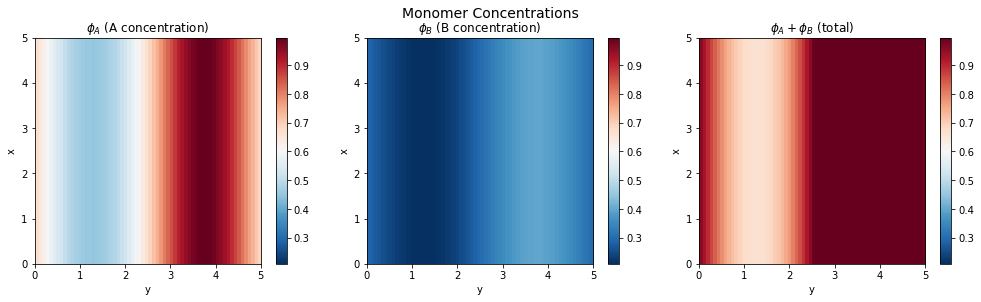


Observation: A monomers concentrate where w_A < 0 (left side)
             B monomers concentrate where w_B < 0 (right side)
             Total concentration φ_A + φ_B ≈ 1 everywhere (incompressibility)


In [11]:
# Visualize concentrations
vmin = min(phi_A.min(), phi_B.min())
vmax = max(phi_A.max(), phi_B.max())

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle("Monomer Concentrations", fontsize=14)

im0 = axes[0].imshow(phi_A, extent=(0, lx[1], 0, lx[0]), origin='lower', 
                      cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[0].set(title='$\phi_A$ (A concentration)', xlabel='y', ylabel='x')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(phi_B, extent=(0, lx[1], 0, lx[0]), origin='lower', 
                      cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[1].set(title='$\phi_B$ (B concentration)', xlabel='y', ylabel='x')
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(phi_A + phi_B, extent=(0, lx[1], 0, lx[0]), origin='lower', 
                      cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[2].set(title='$\phi_A + \phi_B$ (total)', xlabel='y', ylabel='x')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

print("\nObservation: A monomers concentrate where w_A < 0 (left side)")
print("             B monomers concentrate where w_B < 0 (right side)")
print("             Total concentration φ_A + φ_B ≈ 1 everywhere (incompressibility)")

## 7. Visualize Propagator Evolution

The chain propagator $q^{0 \rightarrow 1}_0(\mathbf{r}, s)$ evolves along the chain contour $s$:
- At $s = 0$: Uniform (chain end can start anywhere with equal probability)
- As $s$ increases: Propagator concentrates where the potential is favorable (low $w$)
- At $s = f_A = 0.7$: We've traversed the entire A block

**Important:** The evolution in $s$ is NOT physical time — it's traversal along the polymer backbone. Each step in $s$ corresponds to adding one more monomer to the chain.

This animation shows the forward propagator $q^{0 \rightarrow 1}_0$ from node 0 to node 1 (the A block):

In [17]:
# Get propagator at different contour positions
# Parameters: polymer=0, v=0 (start node), u=1 (end node), step
p, v, u = 0, 0, 1  # Polymer 0, from node 0 to node 1
n_steps_A = int(f_A / ds)  # Number of steps in A block

# Create animation
fig, ax = plt.subplots(figsize=(8, 6))

# Initial frame
q_initial = np.reshape(solver.get_propagator(polymer=p, v=v, u=u, step=0), nx)
im = ax.imshow(q_initial, extent=(0, lx[1], 0, lx[0]), origin='lower', 
               cmap='hot', vmin=0, vmax=2)
ax.set(xlabel='y', ylabel='x')
title = ax.set_title('$q^{0 \\rightarrow 1}_0(r, s=0.00)$')
plt.colorbar(im, ax=ax, label='$q^{0 \\rightarrow 1}_0$')

def update(frame):
    q = np.reshape(solver.get_propagator(polymer=p, v=v, u=u, step=frame), nx)
    im.set_array(q)
    s_value = frame * ds
    title.set_text(f'$q^{{0 \\rightarrow 1}}_0(r, s={s_value:.2f})$')
    return [im, title]

anim = animation.FuncAnimation(fig, update, frames=n_steps_A, 
                                interval=50, repeat=True)
plt.close(fig)

# Display animation
HTML(anim.to_jshtml())

## 8. Summary

In this tutorial, we learned:

1. **PropagatorSolver** provides a simple interface for setting up polymer simulations
2. **Potential fields** $w_\alpha(\mathbf{r})$ control where monomers prefer to be
3. **Chain propagators** $q(\mathbf{r}, s)$ describe the statistical weight of chain conformations
4. **Partition function** $Q$ is the normalization constant for all conformations
5. **Concentrations** $\phi_\alpha(\mathbf{r})$ give the ensemble-averaged monomer density

### Next Steps

- **Branched polymers**: See `BranchedMultiArmStar.ipynb` and `BranchedComb.ipynb`
- **Polymer mixtures**: See `Mixture.ipynb`
- **Non-periodic boundaries**: See `NonPeriodicBC.ipynb`
- **Self-consistent field theory**: See `../SelfConsistentFieldTheory/NaiveSCFT.ipynb`

---

## Appendix: Using the Low-Level Factory API

For advanced users who need more control, here's how to use the factory pattern directly:

In [9]:
# Low-level factory API (for advanced users)
# This gives you more control over computational optimization

# 1. Create factory
factory = polymerfts.PlatformSelector.create_factory("cpu-mkl", False, "real")

# 2. Create computation box
cb = factory.create_computation_box(nx, lx)

# 3. Create molecules information
molecules = factory.create_molecules_information("continuous", ds, {"A": 1.0, "B": 1.0})
molecules.add_polymer(1.0, [["A", f_A, 0, 1], ["B", f_B, 1, 2]])

# 4. Create propagator optimizer (enables computation reuse for branched polymers)
prop_opt = factory.create_propagator_computation_optimizer(molecules, True)

# 5. Create solver
adv_solver = factory.create_pseudospectral_solver(cb, molecules, prop_opt)

# 6. Compute propagators
adv_solver.compute_propagators({"A": w_A.flatten(), "B": w_B.flatten()})

print(f"Q (from factory API) = {adv_solver.get_total_partition(0):.6f}")

Q (from factory API) = 1.044849
